## 0 - Set-up
Like in R Markdown, there can be multiple chunks of text and code. First, we begin with importing the necessary tools from relevant libraries.

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True' # this line of code is needed just for Mac

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D

from sklearn.linear_model import LogisticRegression

%config InlineBackend.figure_format = 'retina'
%matplotlib inline
plt.style.use('ggplot')

Using TensorFlow backend.


## 1 - Exploratory Data Analysis

In machine learning, it is common for the data to be high-dimensional and not very interpretable. It would be a good idea to familiarize ourselves with the dataset before continuing our analysis.

#### 1.1 - Loading the data

In this tutorial, we are interested in the MNIST handwritten digits dataset. Luckily for us, this dataset is one of the benchmark datasets widely used in the machine learning literature, so it is readily available in packages. More information about this database available on its [Wikipedia](https://en.wikipedia.org/wiki/MNIST_database) page and [here](http://yann.lecun.com/exdb/mnist/).

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

#### 1.2 - Visualizing the data

In [3]:
index = 1234 # between 0 and 60000

Number label: 3


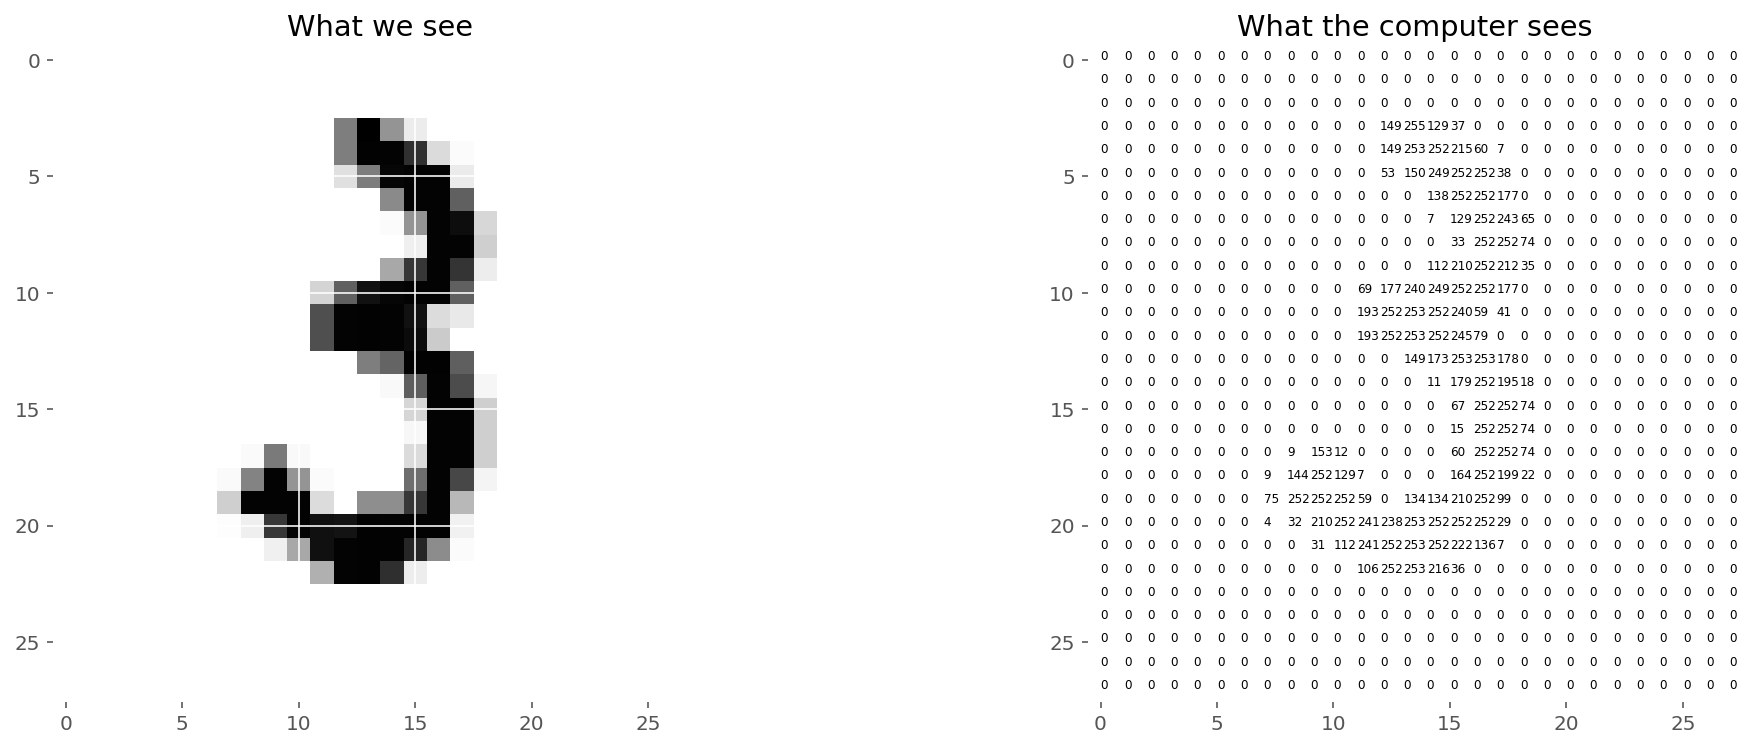

In [4]:
print('Number label: ' + str(y_train[index]))
fig = plt.figure(figsize=(17, 6))
ax1 = fig.add_subplot(121)
ax1 = plt.imshow(x_train[index], cmap='Greys')
ax1 = plt.title('What we see')
ax2 = fig.add_subplot(122)
ax2 = plt.imshow(np.zeros_like(x_train[index]), cmap='Greys')
for i in range(28):
    for j in range(28):
        digit = x_train[index][i][j]
        ax2 = plt.text(j, i, x_train[index][i][j], fontsize=6)
ax2 = plt.title('What the computer sees')

Other examples of handwritten digits in the MNIST dataset.

<img src="images/mnist.png"  width="600"/>

###### Why are there multiple Python packages for machine learning? Don't they do the same thing?


###### What is the difference between the train and test dataset?

#### 1.3 - Verifying how the data is encoded

In [5]:
print(x_train.shape)
print(x_train[index].shape)

(60000, 28, 28)
(28, 28)


The entire dataset is encoded as a 3-dimensional matrix. In other words, you can think of it as a vector of matrices:
$$\texttt{x_train} = \left[\text{digit}_1, \text{digit}_2, \dots, \text{digit}_{60\,000}\right]$$
where $\text{digit}_i$ is itself a $(28 \times 28)$ matrix where $i$ is any index between $1$ and $60\,000$.

In [6]:
print(x_train[index])

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0 149 255 129  37   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0 149 253 252 215  60   7
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0  53 150 249 252 252  38
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0 138 252 252 177
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   7 129 252 243
   65   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  3

###### What if our pictures were in colour?

Would we still be able to do machine learning? What would be different?

## 2 - Classification

A.k.a. supervised learning

#### 2.1 - Brainstorm
Before jumping right into neural networks... what are we trying to do? Let us think about the classification task from different perspectives:
1. Intuition
    - In words, what are we trying to do?
    - What would we want our "machine" to learn?
2. Statistical
    - How should we formulate our problem using math?
    - What are our covariates?
3. Implementation
    - How should we formulate our problem using code (i.e. in Python)?
    - Data pre-processing
4. Computational
    - Are there any possible computational challenges?
    - After all, machine learning is more powerful and popular nowadays due to the availability of data and due to advanced computational resources.

#### 2.2 - Data pre-processing
Data can be undesirably messy in many ways:

- Structure of data can be difficult to be understood for humans
- Encoding of data may not be adequate for available tools
- Format of data may not appropriate or difficult to deal with (e.g. .csv, .dat, .txt, etc.)
- ...many other issues are also possible

In [7]:
x_train = x_train.reshape(-1, 28, 28, 1)
x_train = x_train.astype(float)
x_test  = x_test.reshape(-1, 28, 28, 1)
x_test  = x_test.astype(float)

y_train = keras.utils.to_categorical(y_train, num_classes=10)
y_test  = keras.utils.to_categorical(y_test, num_classes=10)

```x_train[1234]:```
$$
\begin{bmatrix}
    0 & 0 & 0 & 0 &\dots\\
    0 & 0 & 149 & 255 & \dots\\
    0 & 0 & 149 & 253 & \dots \\
    0 & 0 & 53 & 150  & \dots\\
    0 & 0 & 0  & 138 & \dots\\
    \vdots & \vdots & \vdots &\vdots & \ddots
\end{bmatrix}_{\,(28 \times 28)} \rightarrow \qquad
\begin{bmatrix}
    [0] & [0] & [0] & [0] &\dots\\
    [0] & [0] & [149] & [255] & \dots\\
    [0] & [0] & [149] & [253] & \dots \\
    [0] & [0] & [53] & [150]  & \dots\\
    [0] & [0] & [0]  & [138] & \dots\\
    \vdots & \vdots & \vdots &\vdots & \ddots
\end{bmatrix}_{\,(28 \times 28 \times 1)}$$

```y_train[1234]:```
$$3 \rightarrow \left[0, 0, 0, 1, 0, 0, 0, 0, 0, 0\right]$$

## 3 - Model Implementation

#### 3.1 - What is our model?

In this tutorial, we will be using one of the simplest yet one of the most fundamental neural network structures commonly used in machine learning: multilayer perceptron (MLP).

<tr>
    <center>
    <td><img src="images/mlp_handdrawn.png"  width="350"/></td>
    <td><img src="images/mlp.png"  width="450"/></td>
</tr>

#### 3.2 - Building our Keras model

In [8]:
model = Sequential()
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))

W0923 07:43:27.902741 4699772352 deprecation_wrapper.py:119] From /anaconda3/envs/ml/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.



##### What does each line mean?
```model = Sequential()``` &rarr; Model initialization

```model.add(Flatten())``` &rarr; We're "flattening" the images for our multilayer perceptron

```model.add(Dense(128, activation='relu'))``` &rarr; We're adding one layer of hidden units with 128 nodes/"neurons"

```model.add(Dense(10, activation='softmax'))``` &rarr; Output layer

#### 3.3 - Training!

###### What does training mean?

Recall that in linear regression, we are attempting to minimize a criteria called the "least squares":
\begin{align*}
    \Phi(\beta_0, \beta_1) = \sum_{i=1}^n \left(y_i -\beta_0 - \beta_1 x_i \right)^2
\end{align*}

This criteria can also be referred as a "loss function" and our goal is to find parameter values that yields the smallest possible loss. Unlike in linear regession, with neural networks, we are unable to find an analytical solution to the required weights. On top of that, unlike in logistical regression, we are unable to use the Newton-Raphson as a numerical method due to the neural network's complexity and lack in statistical specification (i.e. likelihood not written out for the MLP).

In this case and for most scenarios where neural networks are used, some sort of loss criterion - often largely inspired from statistics - is defined and the goal of machine learners is to minimize this function via a step-wise approach.

- Neural networks as a black box: Modern networks often times have hundreds of millions of parameters, sometimes even billions
- Since we have so many parameters to learn, need lots of data 

In [9]:
model.compile(optimizer='adam', 
              loss=keras.losses.categorical_crossentropy,
              metrics=['accuracy'])
model.fit(x=x_train,
          y=y_train, 
          epochs=5)

W0923 07:43:27.991557 4699772352 deprecation_wrapper.py:119] From /anaconda3/envs/ml/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0923 07:43:28.044095 4699772352 deprecation_wrapper.py:119] From /anaconda3/envs/ml/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0923 07:43:28.084681 4699772352 deprecation_wrapper.py:119] From /anaconda3/envs/ml/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0923 07:43:28.152410 4699772352 deprecation_wrapper.py:119] From /anaconda3/envs/ml/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.

W0923 07:43:28.296993 4699772352 deprecation.py:323] From /anaconda3/envs/m

Epoch 1/5
60000/60000 [==============================] - 14s 230us/step - loss: 7.9605 - acc: 0.5038
Epoch 2/5
60000/60000 [==============================] - 12s 208us/step - loss: 7.3601 - acc: 0.5423
Epoch 3/5
60000/60000 [==============================] - 12s 208us/step - loss: 7.3818 - acc: 0.5412
Epoch 4/5
60000/60000 [==============================] - 18s 293us/step - loss: 6.9670 - acc: 0.5672
Epoch 5/5
60000/60000 [==============================] - 17s 285us/step - loss: 5.8600 - acc: 0.6357


###### What are epochs?

An epoch is the number of times the model/predictor will see the entire training dataset. Here, we trained the model for 5 epochs, meaning that we are "feeding" the batch of data to the neural network.

###### GPUs

Great for running parallel computations and video games. Unfortunately, the laptop you're using is not as strong as some supercomputers whose sole purpose is to perform such tedious computations. Very often, we will use such cloud services to train our machine learning models.

###### Why the separation between train and test datasets?

- Learning vs. memorizing
- Generalizability vs. overfitting

## 4 - Analysis of results

#### 4.1  - Accuracy

Shall we look at the performance on the train or test subset of the data?

In [10]:
pred_test = model.predict(x=x_test)
accuracy_test = np.mean(np.argmax(pred_test, axis=1) == np.argmax(y_test, axis=1))
print('The accuracy of the model evaluated on the test dataset is: {}%'.format(np.around(accuracy_test*100, 1)))

The accuracy of the model evaluated on the test dataset is: 66.4%


###### Do we expect the accuracy to be higher in the training set or in the test set?

In [11]:
pred_train = model.predict(x=x_train)
accuracy_train = np.mean(np.argmax(pred_train, axis=1) == np.argmax(y_train, axis=1))
print('The accuracy of the model evaluated on the train dataset is: {}%'.format(np.around(accuracy_train*100, 1)))

The accuracy of the model evaluated on the train dataset is: 65.9%


#### 4.2 - Visualization

In [12]:
index = 1234 # can reset, needs to be between 1 and 10 000

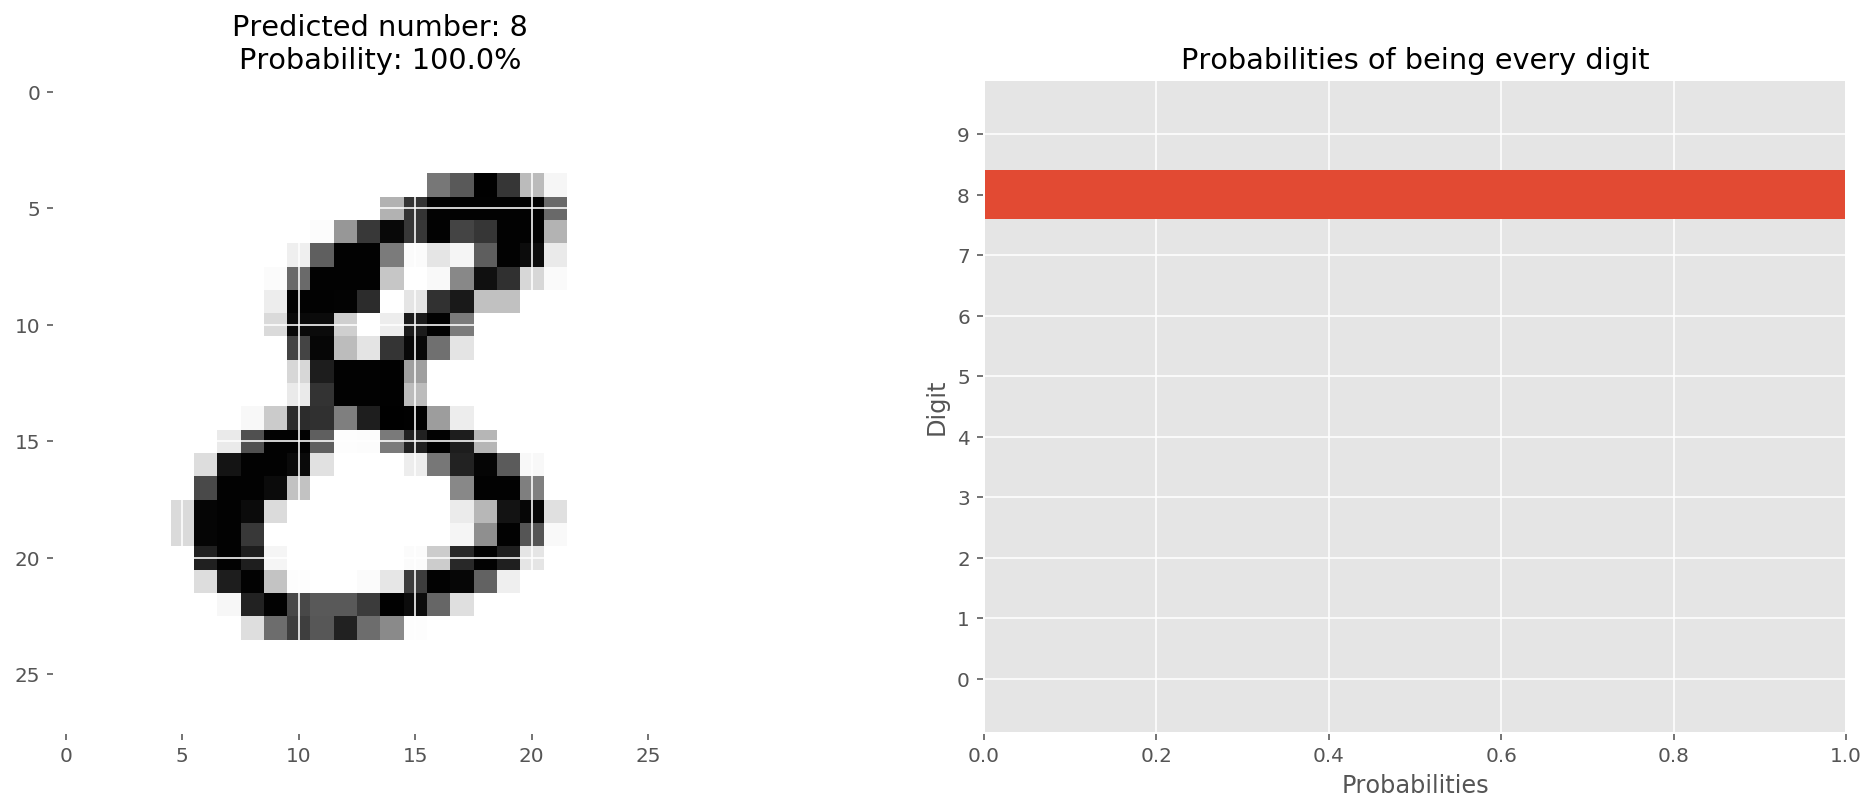

In [13]:
fig = plt.figure(figsize=(17, 6))
ax1 = fig.add_subplot(121)
ax1 = plt.imshow(x_test[index].reshape(28, 28), cmap='Greys')
ax1 = plt.title('Predicted number: {}\nProbability: {}%'.format(str(np.argmax(pred_test[index])), np.around(max(pred_test[index])*100), 2))
ax2 = fig.add_subplot(122)
ax2 = plt.title('Probabilities of being every digit')
ax2 = plt.barh(list(range(10))[::-1], 
               pred_test[index][::-1])
ax2 = plt.xlabel('Probabilities')
ax2 = plt.ylabel('Digit')
ax2 = plt.yticks(range(10))
ax2 = plt.xlim(0, 1)

#### 4.2.1 Visualization of incorrect prediction?

###### What numbers do we expect to be incorrectly predicted?
###### Using code, how to find places where the indices are incorrect?

In [14]:
def find_error(y, pred, index=0):
    '''
    y:    y_train or y_test
    pred: pred_train or pred_test
    '''
    error_indices = np.argwhere(np.argmax(y, axis=1) != np.argmax(pred, axis=1)).reshape(-1,)
    
    return error_indices[index]

In [15]:
index = find_error(y_test, pred_test, 41) # between 0 and 615

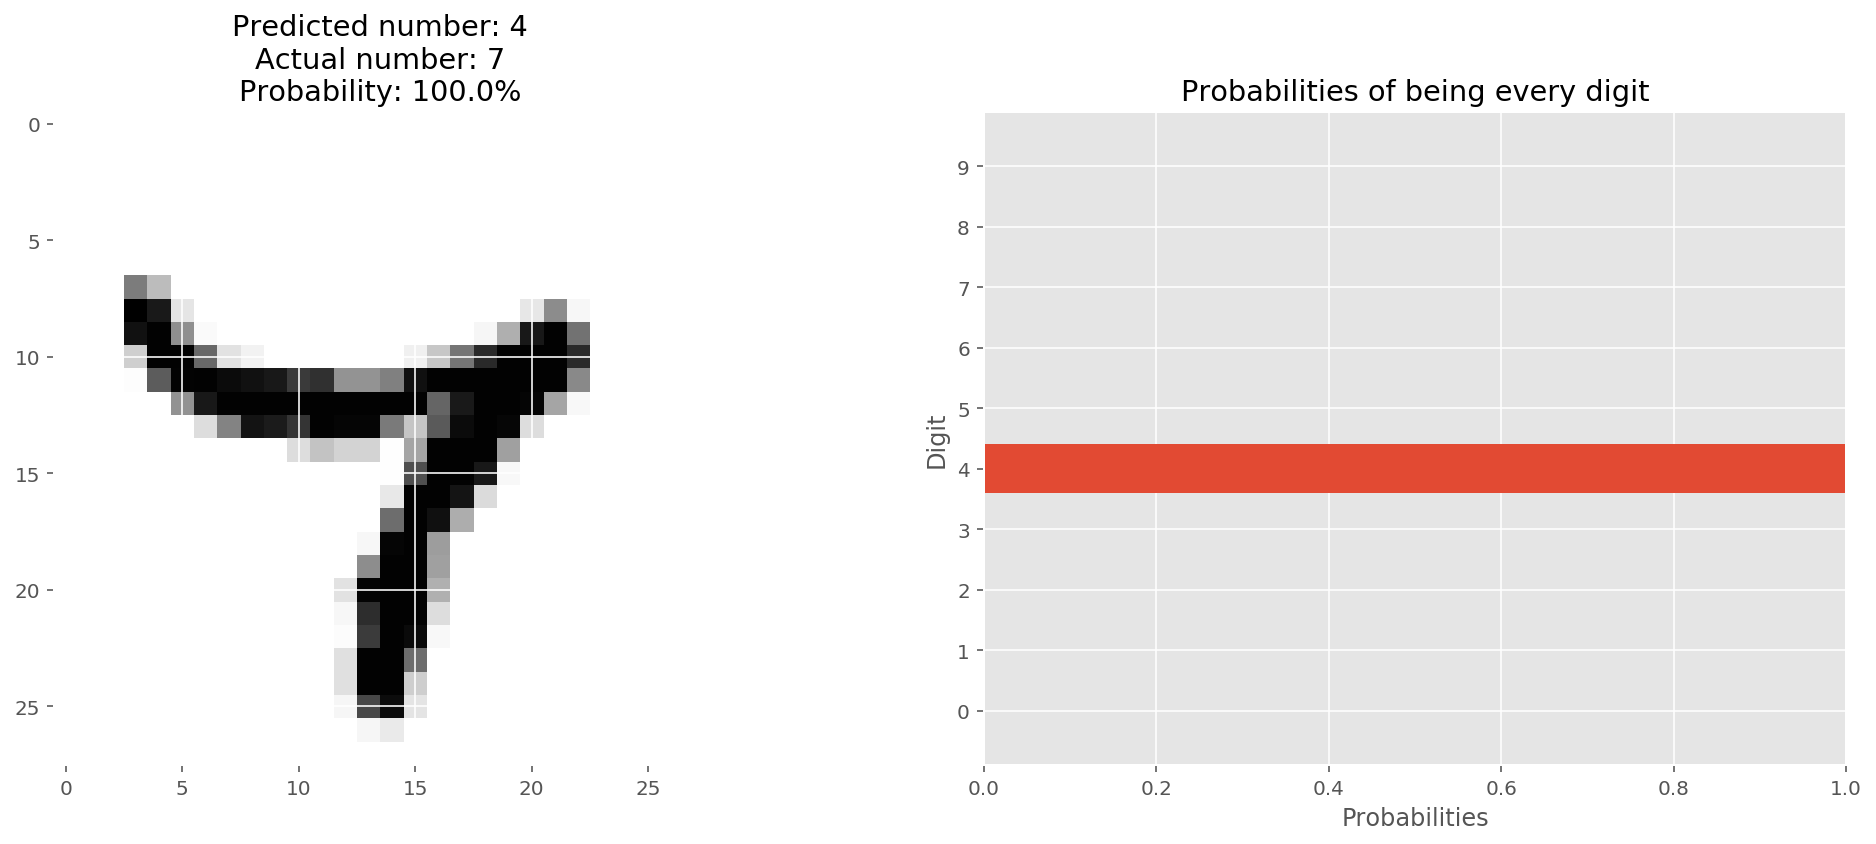

In [16]:
fig = plt.figure(figsize=(17, 6))
ax1 = fig.add_subplot(121)
ax1 = plt.imshow(x_test[index].reshape(28, 28), cmap='Greys')
ax1 = plt.title('Predicted number: {}\nActual number: {}\nProbability: {}%'.format(str(np.argmax(pred_test[index])), np.argmax(y_test[index]), np.around(max(pred_test[index])*100), 2))
ax2 = fig.add_subplot(122)
ax2 = plt.title('Probabilities of being every digit')
ax2 = plt.barh(list(range(10))[::-1], 
               pred_test[index][::-1])
ax2 = plt.xlabel('Probabilities')
ax2 = plt.ylabel('Digit')
ax2 = plt.yticks(range(10))
ax2 = plt.xlim(0, 1)

###### What do you notice?

Our predictor seems quite "confident" in their incorrect predictions.

#### 4.4 - Loss function

###### If we plotted the loss function vs. the iteration number in the training process, what do we expect?

## 5 - Discussion

###### Are neural networks good models?

###### Is our data good?

###### Could we have done better?

Hyperparameter tuning, more epochs, etc.

###### Are we satisfied?

## 6 - Introducing the Convolutional Neural Network (CNN)

#### 6.1 - Coding up the model

In [17]:
cnn = Sequential()
cnn.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu'))
cnn.add(Conv2D(64, (3, 3), activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(Dropout(0.25))
cnn.add(Flatten())
cnn.add(Dense(128, activation='relu'))
cnn.add(Dropout(0.25))
cnn.add(Dense(10, activation='softmax'))

#### 6.2 - Training!

In [ ]:
cnn.compile(optimizer='adam', 
            loss=keras.losses.categorical_crossentropy,
            metrics=['accuracy'])
cnn.fit(x=x_train,
        y=y_train, 
        epochs=10)

W0923 07:44:46.120446 4699772352 deprecation_wrapper.py:119] From /anaconda3/envs/ml/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0923 07:44:46.136518 4699772352 deprecation.py:506] From /anaconda3/envs/ml/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Epoch 1/10
58944/60000 [============================>.] - ETA: 2s - loss: 12.9994 - acc: 0.1933

All the analysis done above can be repeated here as well. We should expect better preformance (i.e. prediction accuracy).